### Core collapse

Heat trasnfer due to self interactions can lead to core collapse of SIDM halos, particularly at high cross sections. This process can be accelerated if the halos exist in a tidal field (i.e. are subhalos). 

In [2]:
from sidmpy.CrossSections.power_law import PowerLaw
from sidmpy.CrossSections.tchannel import TChannel
from sidmpy.CrossSections.velocity_independent import VelocityIndependentCrossSection
from sidmpy.core_collapse_timescale import evolution_timescale
from sidmpy.Solver.util import nfw_velocity_dispersion

rhos, rs = 21959479.819181114, 0.5909608790065194 # for a 10^8 halo at z = 0.5
cross_norm = 5.
kwargs_cross_section = {'norm': cross_norm, 'v_ref': 30}
cross = TChannel(**kwargs_cross_section)

# can use the velocity dispersion insize the scale radius as a characteristic velocity scale
# this is pretty close to the velocity dispersion you get for the SIDM profile
v = nfw_velocity_dispersion(rs, rhos, rs)
velocity_averaged_cross_section = cross.momentum_transfer_cross_section(v)
print(velocity_averaged_cross_section)
t0 = evolution_timescale(rhos, rs, velocity_averaged_cross_section)
print(t0)


4.375342418308169
1.0606465545908061


## Timescales for subhalos and field halos

Eventually, all SIDM halos should undergoe core collapse. The timescale for this process depends on the strength of the interaction cross section and other processes like tidal stripping. Depending on these factors, it can be much longer than, comparable, or shorter than the age of the Universe. 

Nishikawa et al. 2020 (https://arxiv.org/pdf/1901.00499.pdf) track SIDM halos in the field, and compare their evolution with subhalos with similar physical properties. They find that isolated halos in the field build up their cores until t \sim 50*t0, and then begin to contract until $t = 350 t_0$. On the other hand, a tidally truncated halo builds up a core until $t \sim 5 t_0$, and core collapse occurs by $t = 20-50 t_0$, depending on exactly how long the halo exists in the tidal field. We will consider characteristic core collapse time scales of $20 t_0$ and $200 t_0$ for subhalos and field halos, respectively. 

In [3]:
t_sub = t0 * 20
t_field = t0 * 200
print(t_sub, t_field)

21.212931091816124 212.12931091816122


### Core collapse timescale as a function of halo mass and redshift.

#### Note: this cell requires the software package pyHalo

There is a dependence on the timescale for core collapse that stems from the velocity-dependence of the cross section. The first panel shows how the timescale for core collapse changes with halo mass, while the next two panels show the cross section as a function of velocity and as a function of halo mass. To map from a halo mass to a cross section I use the velocity dispersion inside the scale radius of the corresponding NFW halo as a reference speed.

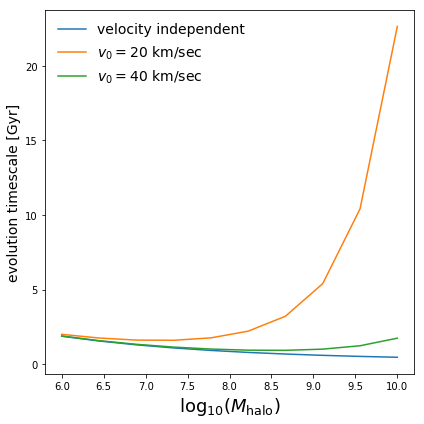

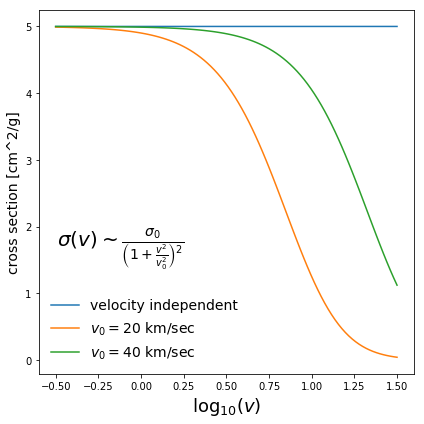

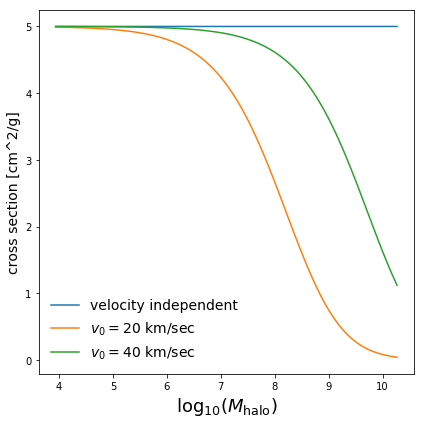

In [10]:
from pyHalo.Halos.lens_cosmo import LensCosmo
import numpy as np
from sidmpy.Solver.util import nfw_velocity_dispersion, nfw_mass_from_velocity_dispersion
import matplotlib.pyplot as plt

lc = LensCosmo()
timescale_v_independent = []
timescale_tchannel_w10 = []
timescale_tchannel_w30 = []

kwargs_cross_section_w10 = {'norm': 5., 'v_ref': 10}
kwargs_cross_section_w30 = {'norm': 5., 'v_ref': 30}
kwargs_cross_section_v_independent = {'norm': 5., 'v_ref': 20000}
cross_section_w10 = TChannel(**kwargs_cross_section_w10)
cross_section_w30 = TChannel(**kwargs_cross_section_w30)
cross_section_vindep = TChannel(**kwargs_cross_section_v_independent)

z = 0.
m = np.logspace(6, 10, 10)

for mi in m:
    
    c = lc.NFW_concentration(mi, z, scatter=False)
    rhos, rs, _ = lc.NFW_params_physical(mi, c, z)
    v = nfw_velocity_dispersion(rs, rhos, rs)
    
    cross_section_effective = cross_section_vindep.momentum_transfer_cross_section(v)
    t0 = evolution_timescale(rhos, rs, cross_section_effective)
    timescale_v_independent.append(t0)
    
    cross_section_effective = cross_section_w10.momentum_transfer_cross_section(v)
    t0 = evolution_timescale(rhos, rs, cross_section_effective)
    timescale_tchannel_w10.append(t0)
    
    cross_section_effective = cross_section_w30.momentum_transfer_cross_section(v)
    t0 = evolution_timescale(rhos, rs, cross_section_effective)
    timescale_tchannel_w30.append(t0)

timescale_v_independent = np.array(timescale_v_independent)
timescale_tchannel_w10 = np.array(timescale_tchannel_w10)
timescale_tchannel_w30 = np.array(timescale_tchannel_w30)
fig = plt.figure(1)
fig.set_size_inches(6, 6)
ax = plt.subplot(111)
ax.plot(np.log10(m), timescale_v_independent, label='velocity independent')
ax.plot(np.log10(m), timescale_tchannel_w10, label=r'$v_0 = 20$' +' km/sec')
ax.plot(np.log10(m), timescale_tchannel_w30, label=r'$v_0 = 40$' +' km/sec')
ax.set_xlabel(r'$\log_{10} \left(M_{\rm{halo}}\right)$', fontsize=18)
ax.set_ylabel('evolution timescale [Gyr]', fontsize=14)
plt.legend(frameon=False, fontsize=14)
plt.tight_layout()
plt.savefig('collapse_time_vs_halo_mass.pdf')
plt.show()


fig = plt.figure(2)
fig.set_size_inches(6, 6)
ax = plt.subplot(111)
v = np.logspace(-0.5, 1.5, 100)
logv = np.log10(v)
ax.plot(logv, cross_section_vindep.evaluate(v), label='velocity independent')
ax.plot(logv, cross_section_w10.evaluate(v), label=r'$v_0 = 20$' +' km/sec')
ax.plot(logv, cross_section_w30.evaluate(v), label=r'$v_0 = 40$' +' km/sec')
ax.set_xlabel(r'$\log_{10} \left(v\right)$', fontsize=18)
ax.set_ylabel('cross section [cm^2/g]', fontsize=14)
ax.annotate(r'$\sigma\left(v\right) \sim \frac{\sigma_0}{\left(1 + \frac{v^2}{v_0^2}\right)^2}$', xy=(0.05, 0.35), 
            xycoords='axes fraction', fontsize=20)
plt.legend(frameon=False, fontsize=14)
plt.tight_layout()
plt.savefig('interaction_cross_section_vs_v.pdf')
plt.show()

fig = plt.figure(3)
fig.set_size_inches(6, 6)
ax = plt.subplot(111)
meff = nfw_mass_from_velocity_dispersion(v)
logmeff = np.log10(meff)
ax.plot(logmeff, cross_section_vindep.evaluate(v), label='velocity independent')
ax.plot(logmeff, cross_section_w10.evaluate(v), label=r'$v_0 = 20$' +' km/sec')
ax.plot(logmeff, cross_section_w30.evaluate(v), label=r'$v_0 = 40$' +' km/sec')
ax.set_xlabel(r'$\log_{10} \left(M_{\rm{halo}}\right)$', fontsize=18)
ax.set_ylabel('cross section [cm^2/g]', fontsize=14)
plt.legend(frameon=False, fontsize=14)
plt.tight_layout()
plt.savefig('interaction_cross_section_vs_m.pdf')
plt.show()